In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
import dgl
import torch
import numpy as np
import pickle

import matplotlib.pyplot as plt
import networkx as nx

In [9]:
#Loading in the Graph Data with pickle (List of edges)

# Load from pickle file

with open('/content/drive/My Drive/Python/PythonFolder/Pytorch/edge_list.pickle', 'rb') as f:
    edge_list = pickle.load(f)

In [10]:
#Our graph has 34 nodes or inputs
node_count = 34

In [11]:
print(edge_list)

[('0', '8'), ('1', '17'), ('24', '31'), ('13', '33'), ('0', '1'), ('2', '8'), ('0', '19'), ('25', '31'), ('14', '33'), ('0', '2'), ('2', '9'), ('1', '19'), ('28', '31'), ('15', '33'), ('1', '2'), ('0', '10'), ('0', '21'), ('2', '32'), ('18', '33'), ('0', '3'), ('4', '10'), ('1', '21'), ('8', '32'), ('19', '33'), ('1', '3'), ('5', '10'), ('23', '25'), ('14', '32'), ('20', '33'), ('2', '3'), ('0', '11'), ('24', '25'), ('15', '32'), ('22', '33'), ('0', '4'), ('0', '12'), ('2', '27'), ('18', '32'), ('23', '33'), ('0', '5'), ('3', '12'), ('23', '27'), ('20', '32'), ('26', '33'), ('0', '6'), ('0', '13'), ('24', '27'), ('22', '32'), ('27', '33'), ('4', '6'), ('1', '13'), ('2', '28'), ('23', '32'), ('28', '33'), ('5', '6'), ('2', '13'), ('23', '29'), ('29', '32'), ('29', '33'), ('0', '7'), ('3', '13'), ('26', '29'), ('30', '32'), ('30', '33'), ('1', '7'), ('5', '16'), ('1', '30'), ('31', '32'), ('31', '33'), ('2', '7'), ('6', '16'), ('8', '30'), ('8', '33'), ('32', '33'), ('3', '7'), ('0', '17

In [12]:
#With edge data we can build graph
def build_graph(edges):
    g = dgl.DGLGraph()
    g.add_nodes(node_count)
    src, dst = tuple(zip(*edges))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bidirectional
    g.add_edges(dst, src)
    return g

In [13]:
Graph = build_graph(edge_list)

In [15]:
print('We have %d nodes.' % Graph.number_of_nodes())
print('We have %d edges.' % Graph.number_of_edges())

We have 34 nodes.
We have 156 edges.


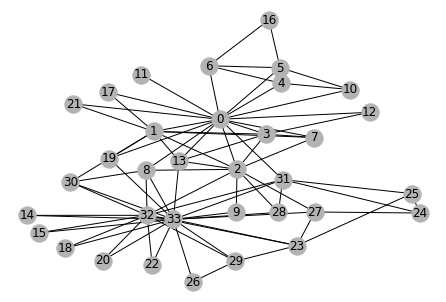

In [17]:
 #Visualizing the nodes
 # Since the actual graph is undirected, we convert it for visualization purpose.
nx_G = Graph.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks good for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [18]:
#Two heavily connected nodes are 0 and 33 which will be our classifier labels.


In [23]:
 import torch.nn as nn
from dgl.nn.pytorch import GraphConv
import torch.nn.functional as F

# build a two-layer GCN with ReLU as the activation in between
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.gcn_layer1 = GraphConv(in_feats, h_feats)
        self.gcn_layer2 = GraphConv(h_feats, num_classes)
        self.softmax = nn.Softmax()
    
    def forward(self, graph, inputs):
        h = self.gcn_layer1(graph, inputs)
        h = F.relu(h)
        h = self.gcn_layer2(graph, h)
        h = self.softmax(h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(34, 5, 2)

In [24]:
 inputs = torch.eye(node_count)
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0,1])  # their labels are different

In [26]:
 optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
all_preds = []
epochs = 30

for epoch in range(epochs):
    preds = net(Graph, inputs)
    all_preds.append(preds)
    # we only compute loss for labeled nodes
    loss = F.cross_entropy(preds[labeled_nodes], labels)

    optimizer.zero_grad() # PyTorch accumulates gradients by default
    loss.backward() 
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0 | Loss: 0.6848
Epoch 1 | Loss: 0.6286
Epoch 2 | Loss: 0.5656
Epoch 3 | Loss: 0.4923
Epoch 4 | Loss: 0.4268
Epoch 5 | Loss: 0.3762
Epoch 6 | Loss: 0.3451
Epoch 7 | Loss: 0.3282
Epoch 8 | Loss: 0.3200
Epoch 9 | Loss: 0.3163
Epoch 10 | Loss: 0.3147
Epoch 11 | Loss: 0.3139
Epoch 12 | Loss: 0.3136
Epoch 13 | Loss: 0.3134
Epoch 14 | Loss: 0.3134
Epoch 15 | Loss: 0.3133
Epoch 16 | Loss: 0.3133
Epoch 17 | Loss: 0.3133
Epoch 18 | Loss: 0.3133
Epoch 19 | Loss: 0.3133
Epoch 20 | Loss: 0.3133
Epoch 21 | Loss: 0.3133
Epoch 22 | Loss: 0.3133
Epoch 23 | Loss: 0.3133
Epoch 24 | Loss: 0.3133
Epoch 25 | Loss: 0.3133
Epoch 26 | Loss: 0.3133
Epoch 27 | Loss: 0.3133
Epoch 28 | Loss: 0.3133
Epoch 29 | Loss: 0.3133


In [27]:
last_epoch = all_preds[epochs-1].detach().numpy()
predicted_class = np.argmax(last_epoch, axis=-1)
color = np.where(predicted_class==0, 'c', 'r')

print(predicted_class)
print(color)

[0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
['c' 'c' 'r' 'c' 'c' 'c' 'c' 'c' 'r' 'r' 'c' 'c' 'c' 'c' 'r' 'r' 'c' 'c'
 'r' 'c' 'r' 'c' 'r' 'r' 'r' 'r' 'r' 'r' 'r' 'r' 'r' 'r' 'r' 'r']


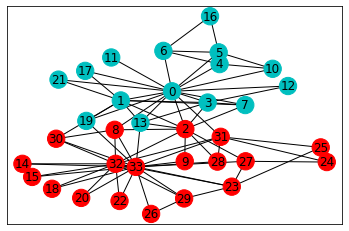

In [28]:
 nx.draw_networkx(nx_G, pos, node_color=color, with_labels=True, node_size=300)